In [2]:
### This notebook compared the magic of Scrooge ensembles wrt the magic of eigenstates

import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy
import itertools
from scipy.special import psi, polygamma
import math

from scipy.linalg import sqrtm
from scipy.linalg import expm
from scipy.optimize import root_scalar

##Libraries in Toby's Code

import time
import operator
from functools import reduce

##Pickle libraries
import pickle
import gzip

In [3]:
#Now, we create the Hamiltonian

def Xp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'X'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Yp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Y'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Zp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Z'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def ZZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'ZZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def YZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'YZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def hlist(N,J,h):
    h_list = [J]
    for i in range(1,N-1):
        h_list.append(h)
    h_list.append(-J)
    return h_list

def H_tfim(N,g,J,h_list):
    op = 0
    for i in range(1,N):
        op += g*Xp(i,N) + h_list[i-1]*Zp(i,N) + J*ZZp(i,N)
    op+=g*Xp(N,N) + h_list[N-1]*Zp(N,N)
    return op

In [4]:
## We have the eigenvalues and eigenfunctions till N = 12, and thus we need to extract pauli spectrum, magic, and EE (subsystem size N//2, even or odd), and store it in a pickle file

def genFockOp(op,position,size,levels=2,opdim=0):
    opList=[qt.qeye(levels) for x in range(size-opdim)]
    opList[position]=op
    return qt.tensor(opList)


def numberToBase(n, b,n_qubits):
    if n == 0:
        return np.zeros(n_qubits,dtype=int)
    digits = np.zeros(n_qubits,dtype=int)
    counter=0
    while n:
        digits[counter]=int(n % b)
        n //= b
        counter+=1
    return digits[::-1]

def get_all_paulis_N(n_qubits):
    ##get all pauli operators
    n_paulis=4**n_qubits

    pauli_list=np.zeros([n_paulis,n_qubits],dtype=int)
    for k in range(n_paulis):
        pauli_list[k,:]=numberToBase(k,4,n_qubits)

    levels=2
    opZ=[genFockOp(qt.sigmaz(),i,n_qubits,levels) for i in range(n_qubits)]
    opX=[genFockOp(qt.sigmax(),i,n_qubits,levels) for i in range(n_qubits)]
    opY=[genFockOp(qt.sigmay(),i,n_qubits,levels) for i in range(n_qubits)]

    
    opId=genFockOp(qt.qeye(levels),0,n_qubits)

    pauli_op_list=[]
    for k in range(n_paulis):
        pauli_string=pauli_list[k]
        pauli=opId
        for i in range(n_qubits):
            if(pauli_string[i]==1):
                pauli=opX[i]*pauli
            elif(pauli_string[i]==2):
                pauli=opY[i]*pauli
            elif(pauli_string[i]==3):
                pauli=opZ[i]*pauli
                
        pauli_op_list.append(pauli)
    return pauli_op_list,pauli_list





def get_conversion_matrix_mod_add_index(base_states):
    ##precompuation for computing renyi stabilizer entropy
    n_qubits=len(base_states[0])
    mag = len(base_states)
    to_index=2**np.arange(n_qubits)[::-1]
    conversion_matrix=np.zeros([mag,mag],dtype=int)
    for j_count in range(mag):
        base_j=base_states[j_count]
        k_plus_j=np.mod(base_states+base_j,2)
        k_plus_j_index=np.sum(k_plus_j*to_index,axis=1)
        conversion_matrix[j_count,:]=k_plus_j_index

    return conversion_matrix

def get_conversion_matrix_binary_prod(base_states):
    ##precompuation for computing renyi stabilizer entropy
    mag = len(base_states)
    conversion_matrix=np.zeros([mag,mag],dtype=int)
    
        
    for i_count in range(mag):
        base_i=base_states[i_count]
        binary_product=np.mod(np.dot(base_states,base_i),2)
        conversion_matrix[i_count,:]=(-1)**binary_product

    return conversion_matrix
def get_eigenvalues_and_eigenfunctions(h,g,N):
    eigvals = np.loadtxt(f"Test_data/mfim_eigvals_h={h},g={g},N={N}.txt")
    eigvecs = np.loadtxt(f"Test_data/mfim_eigvecs_h={h},g={g},N={N}.txt")
    return eigvals, eigvecs

def beta_solver(E_n, H):
    """
    This function solves for beta in the equation Tr(rho(beta) H) = E_n,
    where rho(beta) = exp(-beta H)/Z
    """
    H_qobj = qt.Qobj(H) if not isinstance(H, qt.Qobj) else H

    def f(beta):
        try:
            rho = (-(beta * H_qobj)).expm()
            rho = rho / rho.tr()
            exp_val = expect(H_qobj, rho)
            print(f"beta = {beta}, ⟨H⟩ = {exp_val}")
            return exp_val - E_n
        except Exception as e:
            print(f"Error at beta = {beta}: {e}")
            return np.nan  # Force root_scalar to fail here

    beta = root_scalar(f, bracket=[-0.001, 5], method='bisect',maxiter=30)
    return beta.root

def beta_solver_secant(E_n, H, x0=0.01, x1=0.1):
    """
    Finds β using the secant method without requiring brackets.
    """
    H_qobj = qt.Qobj(H) if not isinstance(H, qt.Qobj) else H

    def f(beta):
        try:
            if beta < 0 or beta > 1e4: return np.nan
            rho = (-beta * H_qobj).expm()
            if rho.norm() < 1e-12: return np.nan
            rho = rho / rho.tr()
            exp_val = qt.expect(H_qobj, rho)
            print(f"beta = {beta}, ⟨H⟩ = {exp_val}")
            return exp_val - E_n
        except Exception:
            return np.nan

    result = root_scalar(f, method='secant', x0=x0, x1=x1, maxiter=100)
    if result.converged:
        return result.root
    raise RuntimeError("Secant method did not converge.")


def beta_solver_grid(E_n, H, beta_min=1e-3, beta_max=1e3, num_points=200):
    """
    Finds β such that Tr[ρ(β) H] = E_n using sign change in log grid.
    """
    H_qobj = qt.Qobj(H) if not isinstance(H, qt.Qobj) else H

    def f(beta):
        try:
            rho = (-beta * H_qobj).expm()
            if rho.norm() < 1e-12: return np.nan
            rho = rho / rho.tr()
            exp_val = qt.expect(H_qobj, rho)
            return exp_val - E_n
        except Exception:
            return np.nan

    betas = np.logspace(np.log10(beta_min), np.log10(beta_max), num_points)
    fvals = [f(b) for b in betas]

    for i in range(len(fvals) - 1):
        if np.isnan(fvals[i]) or np.isnan(fvals[i + 1]):
            continue
        if np.sign(fvals[i]) != np.sign(fvals[i + 1]):
            result = root_scalar(f, bracket=[betas[i], betas[i + 1]], method='bisect', maxiter=50)
            if result.converged:
                return result.root

    raise RuntimeError("No valid beta found with sign change in given range.")


def pauli_spectrum_fast(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod):
    ##fast code to compute renyi entropy which uses numpy to full extent
    #requires precomputation with get_conversion_matrix_binary_prod and get_conversion_matrix_mod_add_index
    coeffs=state  #.data.toarray()[:,0]
    N = int(np.log2(len(coeffs)))
    
    prob_list_full=np.abs(np.dot(np.conjugate(coeffs)*conversion_matrix_binary_prod, coeffs[conversion_matrix_mod_add_index] ))
    
    #print(prob_list_full)
    epsilon_cutoff=10**-15
    prob_list=2**(-N)*prob_list_full[prob_list_full>epsilon_cutoff]

    return prob_list

def pauli_spectrum_fast2(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod):
    ##fast code to compute renyi entropy which uses numpy to full extent
    #requires precomputation with get_conversion_matrix_binary_prod and get_conversion_matrix_mod_add_index
    coeffs=state  #.data.toarray()[:,0]
    N = int(np.log2(len(coeffs)))
    
    prob_list_full=np.abs(np.dot(np.conjugate(coeffs)*conversion_matrix_binary_prod, coeffs[conversion_matrix_mod_add_index] ))**2
    
    #print(prob_list_full)
    epsilon_cutoff=10**-30
    prob_list=2**(-N)*prob_list_full[prob_list_full>epsilon_cutoff]

    return prob_list

def get_magic_exact(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=[2]):
    """
    Computes magic of state using fast pauli spectrum method
    """
    
    prob_list=pauli_spectrum_fast2(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod)
    renyi_fast_list=[]

    N = int(np.log2(len(state)))
    d = 2**N

    for alpha_p in alpha:
        if(alpha_p==1):
            renyi_fast= (-np.sum(prob_list*np.log2(prob_list)) - N)*(d/(d-1))  #-N*np.log(2)


    
        else:
        

            renyi_fast = 1/(1-alpha_p)*(np.log2(np.sum(prob_list**(alpha_p)) - 1/d**alpha_p) + alpha_p*np.log2(d) - np.log2(d-1) ) #-N*np.log(2)

        renyi_fast_list.append(renyi_fast)
    
    
    
    return renyi_fast_list,prob_list

def vn_reduced(phi,Na,N):

    ##Trace out the last N-Na qubits and take von Neumann entropy
    ##phi is a statevector
    ##Na is the number of qubits we want to keep

    ##N is the total number of qubits
    #If not statevectpor, convert to statevector
    if not isinstance(phi, Statevector):
        phi = Statevector(phi)

    keep = list(range(N - Na, N))         # e.g., if N=10, Na=4 → keep [6,7,8,9]
    trace_out = [i for i in range(N) if i not in keep]  # trace out last N - NA qubits

    #trace_out = list(range(Na, N))
    reduced = partial_trace(phi, trace_out)
    return entropy(reduced, base=np.e)





In [45]:
def beta_to_E(beta, H):
    """
    Computes the expectation value of the Hamiltonian for a given beta.
    """
    H_qobj = qt.Qobj(H) if not isinstance(H, qt.Qobj) else H
    rho = (-beta * H_qobj).expm()
    rho = rho / rho.tr()
    return qt.expect(H_qobj, rho)

In [14]:
N_list = [4,5,6,7,8,9,10,11,12]
h=0.35
g=1.1
J=1


##Let us first compute the beta values for the eigenstates of the Hamiltonian
"""for N in N_list:
    print(f"Computing for N = {N}")
    h_list = hlist(N,J,h)
    eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)
    beta_list = []
    index = np.argmin(np.abs(eigvals)) #find eigenvalue closest to 0
    print(f"Index of closest eigenvalue to 0: {index}, Eigenvalue: {eigvals[index]}")
    H = SparsePauliOp.to_matrix(H_tfim(N,g,J,h_list))
    for i in range(index-1):  #Only negative eigenvalues are considered
        print(f"Computing beta for eigenvalue: {eigvals[i]}")
        beta = beta_solver(eigvals[i], H)
        beta_list.append(beta)
    
    with gzip.open(f"Test_data/beta_list_h={h},g={g},N={N}.pkl.gz", "wb") as f:
        pickle.dump(beta_list, f)
    
    print(f"Beta values for N = {N} saved.")
    print()"""



'for N in N_list:\n    print(f"Computing for N = {N}")\n    h_list = hlist(N,J,h)\n    eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)\n    beta_list = []\n    index = np.argmin(np.abs(eigvals)) #find eigenvalue closest to 0\n    print(f"Index of closest eigenvalue to 0: {index}, Eigenvalue: {eigvals[index]}")\n    H = SparsePauliOp.to_matrix(H_tfim(N,g,J,h_list))\n    for i in range(index-1):  #Only negative eigenvalues are considered\n        print(f"Computing beta for eigenvalue: {eigvals[i]}")\n        beta = beta_solver(eigvals[i], H)\n        beta_list.append(beta)\n    \n    with gzip.open(f"Test_data/beta_list_h={h},g={g},N={N}.pkl.gz", "wb") as f:\n        pickle.dump(beta_list, f)\n    \n    print(f"Beta values for N = {N} saved.")\n    print()'

In [28]:
##For now, we compute magic and EE for the eigenstates of the Hamiltonian from index-1 to 0 for all eigenstates

N_list = [11,12]
num_bins = 1000
for N in N_list:
    print(f"Computing magic, pauli probs and EE for N = {N}")
    h_list = hlist(N,J,h)
    eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)
    
    """with gzip.open(f"Test_data/beta_list_h={h},g={g},N={N}.pkl.gz", "rb") as f:
        beta_list = pickle.load(f)"""

    base_states=np.array([numberToBase(i, 2,N) for i in range(2**N)],dtype=int)

    ##these steps need only be run once
    #print("Get magic bases")
    conversion_matrix_binary_prod=get_conversion_matrix_binary_prod(base_states)
    #print("Get mod add base")
    conversion_matrix_mod_add_index=get_conversion_matrix_mod_add_index(base_states)
    #print("Finish magic bases")
    
    # conversion_matrix_mod_add_index, conversion_matrix_binary_prod = qt.get_conversion_matrix_binary_prod(N)
    
    magic_list = []
    ee_list = []
    pauli_probs_list = []
    
    for i in range(len(eigvals)):
        #if eigvals[i] < 0:  # Only consider negative eigenvalues
        start = time.time()
        state = eigvecs[:,i]
        if N <=10:
            magic,pauli_probs = get_magic_exact(state, conversion_matrix_mod_add_index, conversion_matrix_binary_prod, alpha=[0.5,1,2,3])
            pauli_probs_list.append(pauli_probs)
        else:

            magic, pauli_probs_initial = get_magic_exact(state, conversion_matrix_mod_add_index, conversion_matrix_binary_prod, alpha=[0.5,1,2,3])
            ##Convert it into a histogram
            #pauli_probs,bin_edges = np.histogram(pauli_probs_list, bins=np.linspace(-1,1,num_bins+1), density=True)
            #pauli_probs_list.append(pauli_probs)  # Append 0 for the last bin edge
        magic_list.append(magic)  
    
            
        
        # Compute von Neumann entropy for the reduced state
        
        #ee = vn_reduced(state, N//2, N)
        #ee_list.append(ee)
        end = time.time()
        print(f"Computed magic and EE for eigenstate {i} in {end - start:.2f} seconds")

    #if N <=10:
    #    with gzip.open(f"Full_data/pauliprobs_h={h},g={g},N={N}.pkl.gz", "wb") as f:
    #            pickle.dump((pauli_probs_list), f)
    #else:
    #    with gzip.open(f"Full_data/pauliprobhist_h={h},g={g},N={N}.pkl.gz", "wb") as f:
    #        pickle.dump((pauli_probs_list), f)
         
    with gzip.open(f"Full_data/magic_h={h},g={g},N={N}.pkl.gz", "wb") as f:
        pickle.dump((magic_list), f)
    #with gzip.open(f"Full_data/ee_h={h},g={g},N={N}.pkl.gz", "wb") as f:
    #    pickle.dump((ee_list), f)
    
    print(f"Magic, Pauli Probs and EE for N = {N} saved.")
    print()

Computing magic, pauli probs and EE for N = 11
Computed magic and EE for eigenstate 0 in 0.12 seconds
Computed magic and EE for eigenstate 1 in 0.10 seconds
Computed magic and EE for eigenstate 2 in 0.13 seconds
Computed magic and EE for eigenstate 3 in 0.10 seconds
Computed magic and EE for eigenstate 4 in 0.10 seconds
Computed magic and EE for eigenstate 5 in 0.10 seconds
Computed magic and EE for eigenstate 6 in 0.10 seconds
Computed magic and EE for eigenstate 7 in 0.10 seconds
Computed magic and EE for eigenstate 8 in 0.10 seconds
Computed magic and EE for eigenstate 9 in 0.10 seconds
Computed magic and EE for eigenstate 10 in 0.10 seconds
Computed magic and EE for eigenstate 11 in 0.10 seconds
Computed magic and EE for eigenstate 12 in 0.10 seconds
Computed magic and EE for eigenstate 13 in 0.10 seconds
Computed magic and EE for eigenstate 14 in 0.10 seconds
Computed magic and EE for eigenstate 15 in 0.10 seconds
Computed magic and EE for eigenstate 16 in 0.10 seconds
Computed ma

Magic list for N=12: [[np.float64(7.383911446037647), np.float64(5.833071222707987), np.float64(4.136724830184033), np.float64(3.286755230616773)], [np.float64(8.020200883492997), np.float64(6.6419876792802945), np.float64(5.086309081139184), np.float64(4.113165006588856)], [np.float64(8.219772656045386), np.float64(6.827159768853362), np.float64(5.234657805440097), np.float64(4.222941527258358)], [np.float64(8.406944530091259), np.float64(7.082836630722567), np.float64(5.516869394305573), np.float64(4.45038135073464)], [np.float64(8.386561390672625), np.float64(7.059412953051851), np.float64(5.456970635815402), np.float64(4.4085014889715115)], [np.float64(8.546052156167207), np.float64(7.257019371191203), np.float64(5.6978055189491315), np.float64(4.5834240509476505)], [np.float64(8.594661389778928), np.float64(7.28485276153395), np.float64(5.687834557593117), np.float64(4.596889328559561)], [np.float64(8.70651216541625), np.float64(7.479021675506996), np.float64(5.947780566963388), n

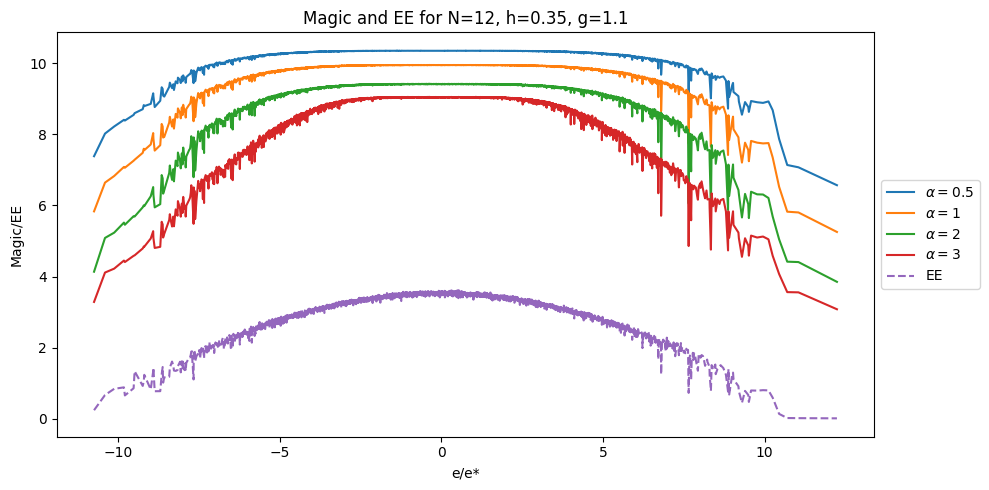

"plt.plot(ee_list)\nplt.title(f'EE for N={N}, h={h}, g={g}')\nplt.xlabel('Eigenstate Index')\nplt.ylabel('EE')\nplt.tight_layout()\nplt.show()"

In [42]:
##Let us plot the magic and EE for the eigenstates of the Hamiltonian
N = 12
with gzip.open(f"Full_data/magic_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    magic_list = pickle.load(f)
with gzip.open(f"Full_data/ee_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    ee_list = pickle.load(f)



#Separate the magic values into respective alphas
magic_alpha_05 = [magic[0] for magic in magic_list]
magic_alpha_1 = [magic[1] for magic in magic_list]
magic_alpha_2 = [magic[2] for magic in magic_list]
magic_alpha_3 = [magic[3] for magic in magic_list]

print(f"Magic list for N={N}: {magic_list}")

#load the eigenenergies
eigvals = np.loadtxt(f"Test_data/mfim_eigvals_h={h},g={g},N={N}.txt")

epsilon_star = np.sqrt(np.var(eigvals)/N)  # Calculate the standard deviation of eigenvalues

eigvals_normalised = eigvals / epsilon_star  # Normalize eigenvalues for better visualization

#Plot these magic and EE values separately, without connecting the points

plt.figure(figsize=(10, 5))
plt.plot(eigvals_normalised,magic_alpha_05,label = r'$\alpha=0.5$')
plt.plot(eigvals_normalised,magic_alpha_1, label = r'$\alpha=1$')
plt.plot(eigvals_normalised,magic_alpha_2, label = r'$\alpha=2$')
plt.plot(eigvals_normalised,magic_alpha_3, label = r'$\alpha=3$')
plt.plot(eigvals_normalised,ee_list, label='EE', linestyle='--')
plt.title(f'Magic and EE for N={N}, h={h}, g={g}')
plt.xlabel('e/e*')
plt.ylabel('Magic/EE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

"""plt.plot(ee_list)
plt.title(f'EE for N={N}, h={h}, g={g}')
plt.xlabel('Eigenstate Index')
plt.ylabel('EE')
plt.tight_layout()
plt.show()"""





In [33]:
##Let us test the beta solver method times
N=12
eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)
H = SparsePauliOp.to_matrix(H_tfim(N,g,J,hlist(N,J,h)))
index = np.argmin(np.abs(eigvals))  # Find eigenvalue closest to 0

test_state = eigvecs[:,index-1]
test_val = eigvals[index-1]
print(f"Testing beta solver for eigenvalue: {test_val}")
"""start_time = time.time()
beta = beta_solver_grid(test_val, H, beta_min=1e-3, beta_max=1e3, num_points=200)
end_time = time.time()
print(f"Computed beta: {beta} in {end_time - start_time:.2f} seconds")"""
# Test the beta solver secant method
"""start_time = time.time()
beta_secant = beta_solver_secant(test_val, H, x0=0.01, x1=0.1)
end_time = time.time()
print(f"Computed beta (secant): {beta_secant} in {end_time - start_time:.2f} seconds")"""
# Test our beta solver method
start_time = time.time()
beta = beta_solver(test_val, H)
end_time = time.time()
print(f"Computed beta: {beta} in {end_time - start_time:.2f} seconds")






Testing beta solver for eigenvalue: -0.0024734547928905665
beta = -0.001, ⟨H⟩ = 0.028748280829705875
beta = 0.01, ⟨H⟩ = -0.28709261010102266
beta = 0.0045, ⟨H⟩ = -0.12928309407963945
beta = 0.0017499999999999998, ⟨H⟩ = -0.05029347788142683
beta = 0.0003749999999999999, ⟨H⟩ = -0.010778908476498457
beta = -0.00031250000000000006, ⟨H⟩ = 0.008983134684335316
beta = 3.124999999999992e-05, ⟨H⟩ = -0.0008982780190482692
beta = 0.0002031249999999999, ⟨H⟩ = -0.005838691434766714
beta = 0.00011718749999999991, ⟨H⟩ = -0.003368509223026805
beta = 7.421874999999992e-05, ⟨H⟩ = -0.0021333997386761994
beta = 9.570312499999992e-05, ⟨H⟩ = -0.0027509560110465688
beta = 8.496093749999991e-05, ⟨H⟩ = -0.002442178257219141
beta = 9.033203124999992e-05, ⟨H⟩ = -0.0025965672298741333
beta = 8.764648437499992e-05, ⟨H⟩ = -0.0025193727674727943
beta = 8.630371093749991e-05, ⟨H⟩ = -0.0024807755184034024
beta = 8.56323242187499e-05, ⟨H⟩ = -0.0024614768893316758
beta = 8.596801757812491e-05, ⟨H⟩ = -0.00247112620424187

8.199243220219365e-05 1.782129374856396 0.008397042652001845 0.03650579753103855


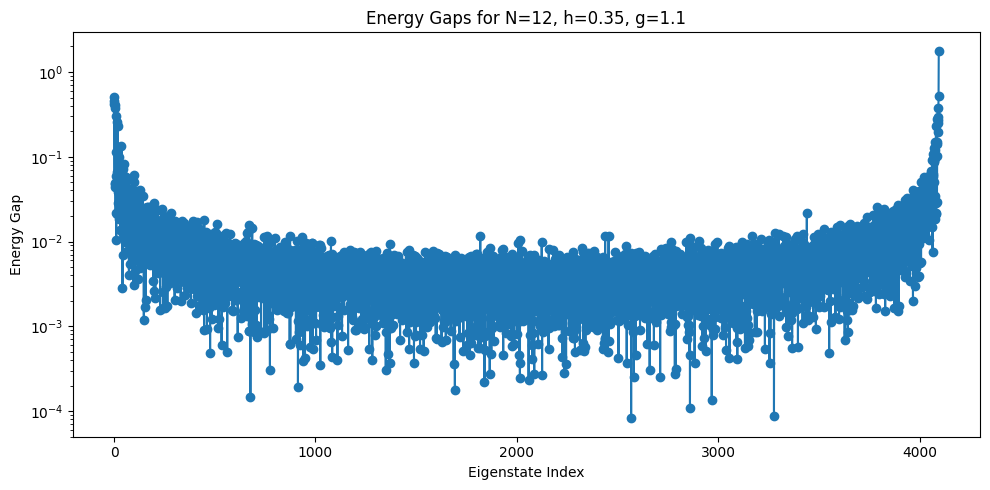

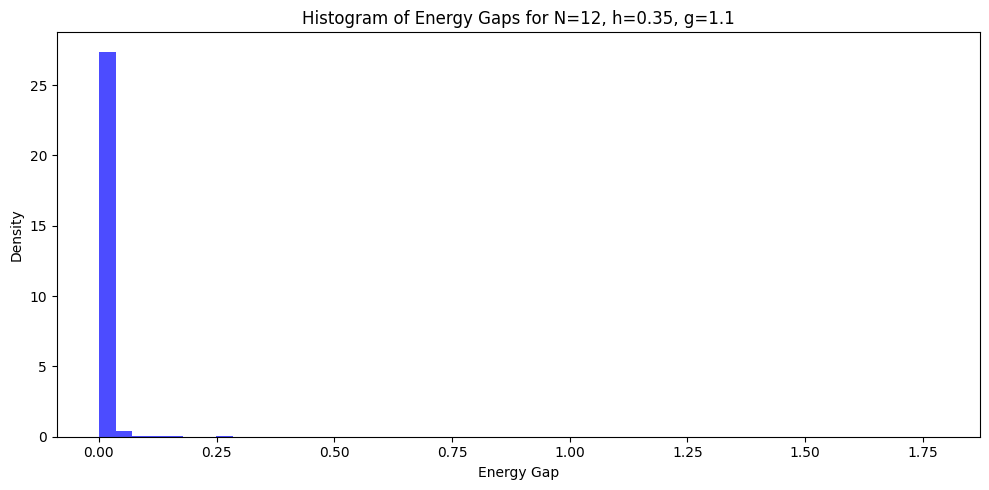

In [ ]:
###degenracies

gap_list = []
N = 12
h_list = hlist(N,J,h)
eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)
for i in range(len(eigvals)-1):
    gap = eigvals[i+1] - eigvals[i]
    gap_list.append(gap)

print(np.min(gap_list), np.max(gap_list), np.mean(gap_list), np.std(gap_list))
plt.figure(figsize=(10, 5))
plt.plot(gap_list, marker='o')
plt.title(f'Energy Gaps for N={N}, h={h}, g={g}')
plt.xlabel('Eigenstate Index')
plt.ylabel('Energy Gap')
plt.yscale('log')
plt.tight_layout()
plt.show()


##Plot the histogram of the gaps
plt.figure(figsize=(10, 5))
plt.hist(gap_list, bins=np.linspace(np.min), density=True, alpha=0.7, color='blue')
plt.title(f'Histogram of Energy Gaps for N={N}, h={h}, g={g}')
plt.xlabel('Energy Gap')
plt.ylabel('Density')
#plt.xscale('log')
plt.tight_layout()
plt.show()

8.199243220219365e-05 1.782129374856396 0.008397042652001845 0.03650579753103855


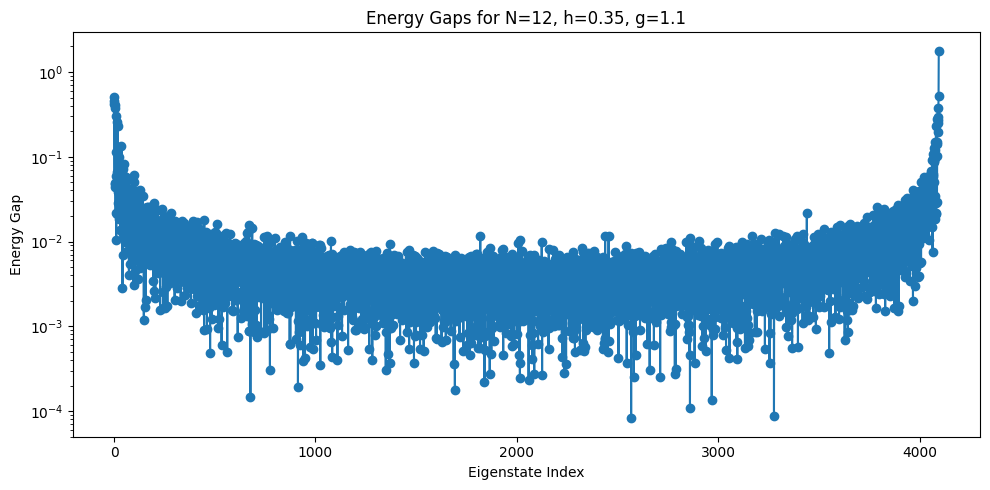

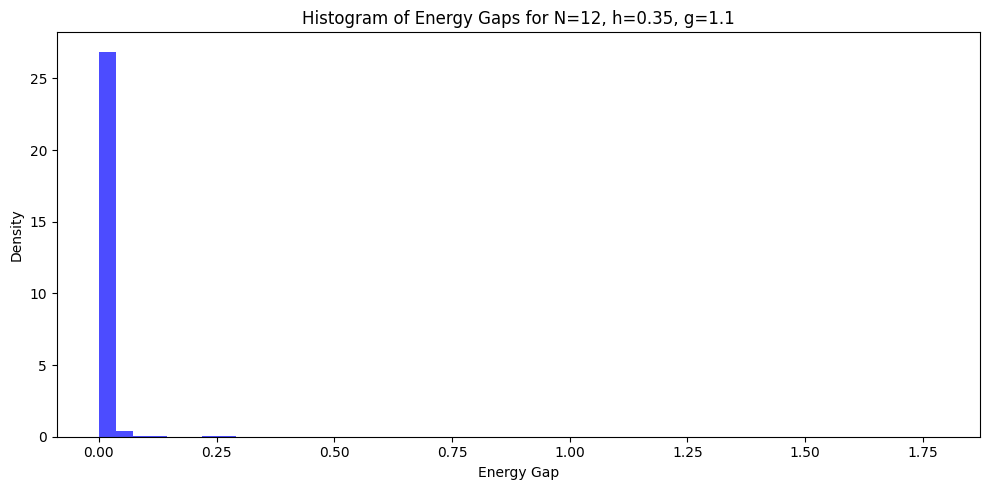

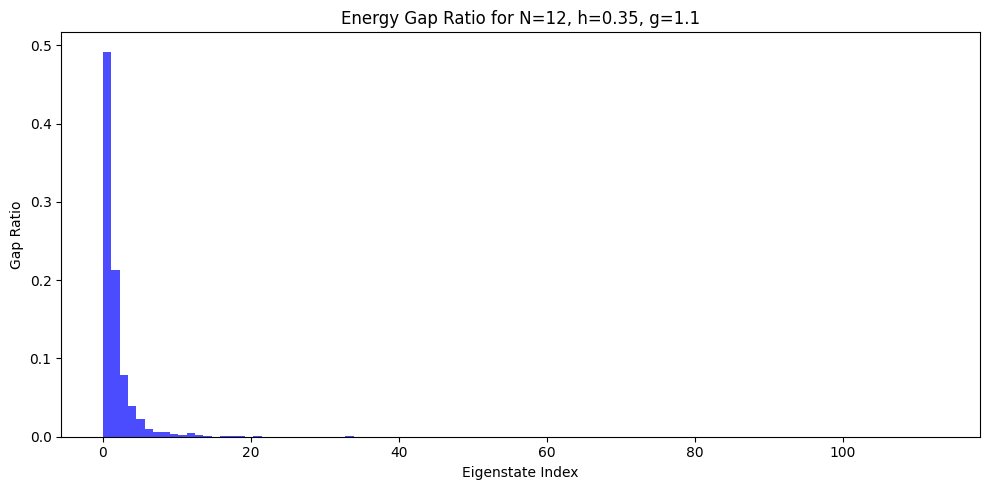

In [39]:
print(np.min(gap_list), np.max(gap_list), np.mean(gap_list), np.std(gap_list))
plt.figure(figsize=(10, 5))
plt.plot(gap_list, marker='o')
plt.title(f'Energy Gaps for N={N}, h={h}, g={g}')
plt.xlabel('Eigenstate Index')
plt.ylabel('Energy Gap')
plt.yscale('log')
plt.tight_layout()
plt.show()


##Plot the histogram of the gaps
plt.figure(figsize=(10, 5))
plt.hist(gap_list, bins=np.linspace(np.min(gap_list),np.max(gap_list),50), density=True, alpha=0.7, color='blue')
plt.title(f'Histogram of Energy Gaps for N={N}, h={h}, g={g}')
plt.xlabel('Energy Gap')
plt.ylabel('Density')
#plt.xscale('log')
plt.tight_layout()
plt.show()

gap_ratio = np.array(gap_list[0:-1])/np.array(gap_list[1:])
plt.figure(figsize=(10, 5))
plt.hist(gap_ratio, bins=100, density=True, alpha=0.7, color='blue')
plt.title(f'Energy Gap Ratio for N={N}, h={h}, g={g}')
plt.xlabel('Eigenstate Index')
plt.ylabel('Gap Ratio')
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [50]:
##Let us first compute the beta lists for each N
N_list = [4,5,6,7,8,9,10,11]
for N in N_list:
    print(f"Computing beta list for N = {N}")

    h_list = hlist(N,J,h)
    eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)
    H = SparsePauliOp.to_matrix(H_tfim(N,g,J,h_list))
    first_excites_val = eigvals[1]  # First excited state

    beta_excited = beta_solver(first_excites_val, H)

    E_list = []

    for beta in np.linspace(-beta_excited, beta_excited, 50):
        start = time.time()
        E = beta_to_E(beta, H)
        end = time.time()
        print(f"Computed E for beta = {beta}: {E} in {end - start:.2f} seconds")
        E_list.append(E)
    coeffs = np.polyfit(E_list, np.linspace(-beta_excited, beta_excited, 50), 3)
    print(f"Polynomial coefficients for E vs Beta: {coeffs}")
    # Create a polynomial function from the coefficients
    poly_func = np.poly1d(coeffs)
    ##Now, we can use this polynomial to first create the beta values for the eigenstates of the Hamiltonian

    beta_list = []
    for E in eigvals:
        beta = poly_func(E)
        beta_list.append(beta)
    # Save the beta values for the eigenstates
    with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N}.pkl.gz", "wb") as f:
        pickle.dump(beta_list, f)
    print()

Computing beta list for N = 4
beta = -0.001, ⟨H⟩ = 0.010085357214494522
beta = 5.0, ⟨H⟩ = -6.266376068760695
beta = 2.4995000000000003, ⟨H⟩ = -6.254933521557414
beta = 1.2492500000000002, ⟨H⟩ = -6.008636997774081
beta = 0.624125, ⟨H⟩ = -4.739050688878215
beta = 0.3115625, ⟨H⟩ = -2.8675889904768623
beta = 0.46784375, ⟨H⟩ = -3.944186818762536
beta = 0.545984375, ⟨H⟩ = -4.375689727438286
beta = 0.5069140625, ⟨H⟩ = -4.168711995991914
beta = 0.5264492187500001, ⟨H⟩ = -4.274368724979642
beta = 0.516681640625, ⟨H⟩ = -4.2220859503873625
beta = 0.5117978515625, ⟨H⟩ = -4.195535787006135
beta = 0.50935595703125, ⟨H⟩ = -4.18215814465965
beta = 0.5105769042968751, ⟨H⟩ = -4.188855523014834
beta = 0.5099664306640626, ⟨H⟩ = -4.185508973902842
beta = 0.5102716674804688, ⟨H⟩ = -4.1871827833793835
beta = 0.510424285888672, ⟨H⟩ = -4.18801928691523
beta = 0.5105005950927735, ⟨H⟩ = -4.188437438393057
beta = 0.5104624404907228, ⟨H⟩ = -4.188228371011338
beta = 0.5104433631896973, ⟨H⟩ = -4.188123831052607
beta

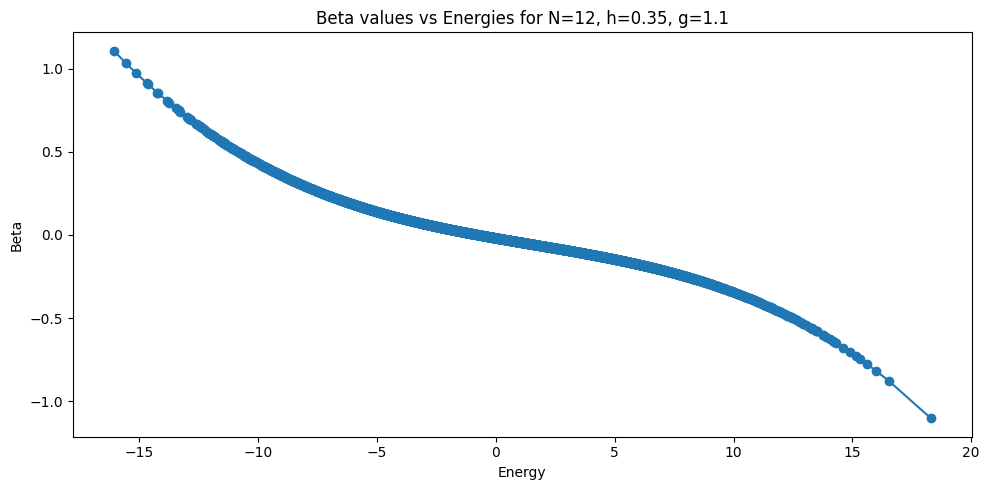

In [7]:
##Plot the beta values v/s energies for N=12
N = 12
h = 0.35
g = 1.1
eigvals, eigvecs = get_eigenvalues_and_eigenfunctions(h,g,N)
with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    beta_list = pickle.load(f)  



plt.figure(figsize=(10, 5))
plt.plot(eigvals, beta_list, marker='o')
plt.title(f'Beta values vs Energies for N={N}, h={h}, g={g}')
plt.xlabel('Energy')
plt.ylabel('Beta')
plt.tight_layout()
plt.show()

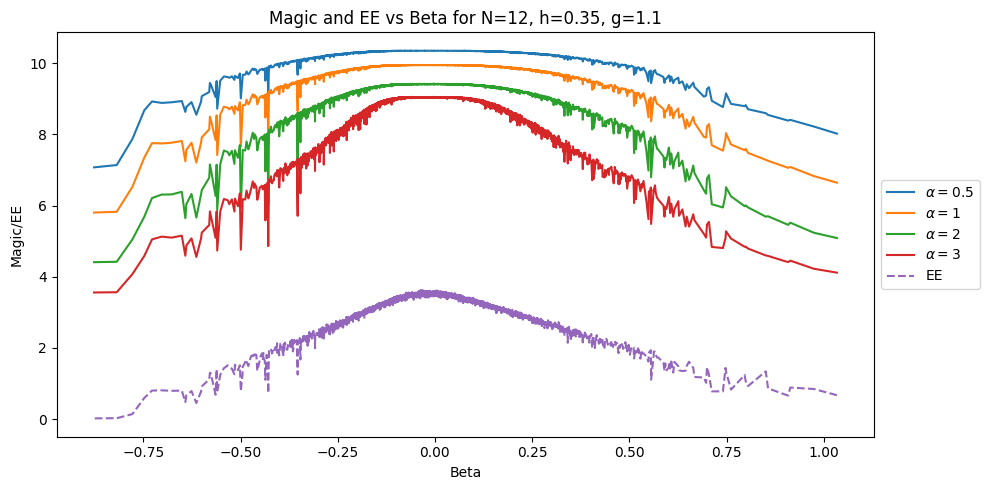

[np.float64(1.1081499529918615), np.float64(1.033929629766889), np.float64(0.9745825579561038), np.float64(0.9140618615853172), np.float64(0.9083723950425995), np.float64(0.8567961426955474), np.float64(0.8508868834954874), np.float64(0.8051197807712475), np.float64(0.7992897206328651), np.float64(0.7966788505616516), np.float64(0.7615271678593745), np.float64(0.7485975080810762), np.float64(0.7474219722588359), np.float64(0.7406765079288783), np.float64(0.7120258810751272), np.float64(0.7047879973982117), np.float64(0.6997390367580779), np.float64(0.6974652160532302), np.float64(0.6918546776144537), np.float64(0.6674248681108633), np.float64(0.6644114294611516), np.float64(0.6576711152813145), np.float64(0.6536902525539489), np.float64(0.6475730720858511), np.float64(0.644643800607077), np.float64(0.6364203165952815), np.float64(0.6278585834873938), np.float64(0.6259882596302986), np.float64(0.6160549016939818), np.float64(0.612884735714368), np.float64(0.6079555813272184), np.float64

In [53]:
##Let us get a functional form for obtaining beta from E_n. We will first calculate E for a buunch of betas and then fit a polynomial to it
#For a given N first, check what is the beta of the first excited state

N = 12
##Get the beta list first
with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    beta_list = pickle.load(f)
#get the magic and ee lists
with gzip.open(f"Full_data/magic_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    magic_list = pickle.load(f)
with gzip.open(f"Full_data/ee_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    ee_list = pickle.load(f)

#Separate the magic values into respective alphas
magic_alpha_05 = [magic[0] for magic in magic_list]
magic_alpha_1 = [magic[1] for magic in magic_list]
magic_alpha_2 = [magic[2] for magic in magic_list]
magic_alpha_3 = [magic[3] for magic in magic_list]

##Now, we can use this polynomial to theplot the magic and EE v/s beta for the eigenstates of the Hamiltonian
plt.figure(figsize=(10, 5))
plt.plot(beta_list[1:-1], magic_alpha_05[1:-1], label=r'$\alpha=0.5$')
plt.plot(beta_list[1:-1], magic_alpha_1[1:-1], label=r'$\alpha=1$')
plt.plot(beta_list[1:-1], magic_alpha_2[1:-1], label=r'$\alpha=2$')
plt.plot(beta_list[1:-1], magic_alpha_3[1:-1], label=r'$\alpha=3$')
plt.plot(beta_list[1:-1], ee_list[1:-1], label='EE', linestyle='--')
plt.title(f'Magic and EE vs Beta for N={N}, h={h}, g={g}')
plt.xlabel('Beta')
plt.ylabel('Magic/EE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

print(beta_list)